# 0. Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

from keras import backend as K
K.set_image_dim_ordering('tf')

from keras.models import load_model
from keras.layers import Dense, Flatten, Conv2D
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.regularizers import l2

# 1. Definition of the CNN architecture

Trained CNN weights loaded in the next part corresponds to the CNN architecture presented below.

In [2]:
def create_model():
    
    # number of ice classes
    nbr_classes = 4  
    # size of SAR subimages
    ws = 50
    # size of convolutional filters
    cs = 3
    # number of filters per convolutional layer (x id)
    c1,c2,c3 = 32,32,32
    # number of neurons per hidden neural layer number (x id)
    n1,n2,n3 = 16,16,64
    # value of dropout
    dropout_rate = 0.1
    # value of L2 regularisation
    l2_rate = 0.001


    model = Sequential()

    # Convolutional part
    model.add(BatchNormalization(input_shape=(ws, ws, 2)))
    model.add(Conv2D(c1, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(Conv2D(c2, (cs, cs), activation='relu'))
    model.add(Conv2D(c3, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(BatchNormalization())

    model.add(Flatten())

    # Neural network part (hidden layers)
    model.add(Dropout(dropout_rate))
    model.add(Dense(n1, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n2,kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n3,kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))

    # Last neural layer (not hidden)
    model.add(Dense(nbr_classes,kernel_regularizer=l2(l2_rate), activation='softmax'))
    
    return model

# 2. CNN application

### 2.1. Import data

In [3]:
data = np.load('CNN_data.npz')

sigma0_HH = data['sigma0_HH']
sigma0_HV = data['sigma0_HV']

#### HH SAR image

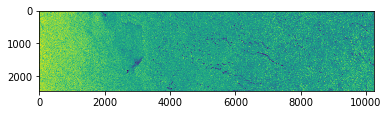

In [4]:
plt.imshow(sigma0_HH)

#### HV SAR image

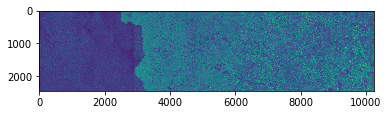

In [5]:
plt.imshow(sigma0_HV)

### 2.1. Create the 50x50x2 SAR subimages

In [6]:
cnn_samples = []
SUBIMAGES_SIZE = 50


y = 0

for i in range (0,sigma0_HH.shape[0] - SUBIMAGES_SIZE//2, SUBIMAGES_SIZE//2):

    x = 0
  
    for j in range (0,sigma0_HH.shape[1] - SUBIMAGES_SIZE//2, SUBIMAGES_SIZE//2):

        HHsub             =     sigma0_HH[i:i+SUBIMAGES_SIZE,j:j+SUBIMAGES_SIZE].reshape(SUBIMAGES_SIZE,SUBIMAGES_SIZE,1)
        HVsub             =     sigma0_HV[i:i+SUBIMAGES_SIZE,j:j+SUBIMAGES_SIZE].reshape(SUBIMAGES_SIZE,SUBIMAGES_SIZE,1)
        HH_HVsub          =     np.concatenate((HHsub, HVsub), axis=2)
     
        cnn_samples.append(HH_HVsub)

        x += 1
    
    y += 1
    
    
mask_size = [y,x]
cnn_samples = np.array(cnn_samples)

### 2.3. Load model and trained weights

In [7]:
# creation of the model 
model = create_model()

# loading the trained weights
model.load_weights("weights.hdf5")

### 2.4. CNN predicitons

In [8]:
CNN_predictions = model.predict(cnn_samples).reshape((mask_size[0],mask_size[1],4))

### 2.5. Build predicted ice chart

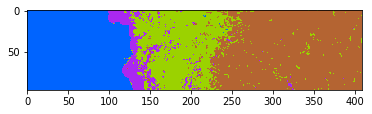

In [9]:
ice_class = np.argmax(CNN_predictions, axis=2)

color_scale = ['#0064FF','#AA28F0','#9BD200','#B46432']
cmap = colors.ListedColormap(color_scale)  

plt.imshow(ice_class, cmap =cmap)

### 2.6. Build probability map

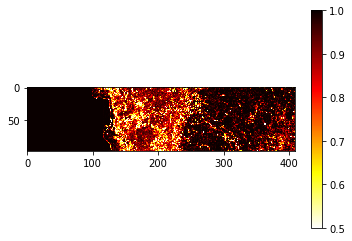

In [10]:
ice_proba = np.max(CNN_predictions, axis=2)

plt.imshow(ice_proba, cmap="hot_r", vmin=0.5,vmax = 1)
plt.colorbar()